In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as torch_data
import torch.nn.functional as F
import random
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as torch_data
from nilearn import plotting
import nibabel as nib
import nilearn
import os
import sys
import pathlib
import functools
from sklearn.model_selection import train_test_split, StratifiedKFold
from torchvision.transforms import *
import time


In [2]:
sys.path.insert(0,'/home/Druzhinina/project')
from data import HCP_MRI

In [14]:
import grad_cam
from meanpertrub import MeanPertrub

random.seed(82)
torch.manual_seed(82)
torch.cuda.manual_seed(82)
np.random.seed(82)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
CHECKPOINTS_DIR = '/home/Druzhinina/project/checkpoints_full/' #best_acc_model_NetGradRandomiz_all_subject_bs42
isTrain = True

In [15]:
PATH_TO_MRI = '/home/datasets/HCP_T1'
data_dir = pathlib.Path('/home/datasets/adni')
behavioral_path = os.path.join(data_dir / 'unrestricted_hcp_freesurfer.csv')
hcp_type = 'MPR1'

HCP absmax before normalization: 435.0126647949219
Dataset size: 1112
Labels distribution: (array([0, 1]), array([605, 507]))

Example:
Image shape: torch.Size([1, 206, 250, 220])
Type: <class 'torch.Tensor'>
Target: 1


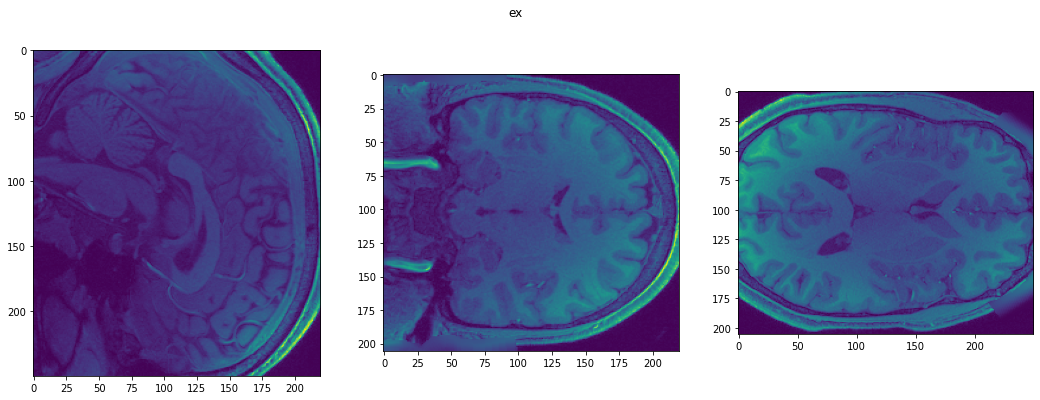

In [16]:
def get_absmax(dataset):
    absmax = 0.
    for (img, target) in dataset:
        img = torch.FloatTensor(img).to(device)
        absmax = max(absmax, img.abs().max().item())
        del img, target
    return absmax

def AbsMaxScale(img, absmax):
    return img / absmax

def plot_central_cuts(img, title="", t=None):
    """
    param image: tensor or np array of shape (CxDxHxW) if t is None
    param image: tensor or np array of shape (TxCxDxHxW) if t is not None
    """
    if t is not None:
        img = img[t]
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(3 * 6, 6))
    fig.suptitle(title)
    axes[0].imshow(img[0, img.shape[1] // 2, :, :])
    axes[1].imshow(img[0, :, img.shape[2] // 2, :])
    axes[2].imshow(img[0, :, :, img.shape[3] // 2])
    plt.show()
    
hcp_dataset = HCP_MRI(
    paths= PATH_TO_MRI,
    target_path= behavioral_path,
    load_online=True,
    hcp_type = hcp_type,
    coord_min=(25,30,50),
    img_shape=(206, 250, 220)
) # 250 320 320  - 44 70 100
hcp_absmax = 435.0126647949219 # get_absmax(la5_dataset)
hcp_dataset.transform = functools.partial(AbsMaxScale, absmax=hcp_absmax)

transform = Compose([
#     BrightnessContrast(),
#     GaussNoise(),
#     Rotate(),
    ToTensor(),
])
hcp_dataset.transform = transform
print("HCP absmax before normalization: {}".format(hcp_absmax))
print("Dataset size: {}".format(len(hcp_dataset)))
print("Labels distribution: {}\n".format(np.unique(hcp_dataset.labels, return_counts=True)))

print("Example:")
img, target = hcp_dataset[0]
print("Image shape: {}".format(img.shape))
print("Type: {}".format(type(img)))
print("Target: {}".format(target))
plot_central_cuts(img, title="ex", t = None)

In [17]:
class MriNetGrad(nn.Module):
    def __init__(self, c):
        super(MriNetGrad, self).__init__()
        self.features = nn.Sequential( 
                nn.Conv3d(1, c, kernel_size=3),
                nn.BatchNorm3d(c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3),
                
                nn.Conv3d(c, 2*c, kernel_size=3),
                nn.BatchNorm3d(2*c),
                nn.ReLU(),
                nn.MaxPool3d(kernel_size=3),
                
                nn.Conv3d(2*c, 4*c, kernel_size=3, stride=1, dilation=1, padding=0),
                nn.BatchNorm3d(4*c),
                nn.ReLU()
        )
        self.classifier = nn.Sequential(
            nn.MaxPool3d(kernel_size=3),
            nn.Flatten(),
            nn.Linear(in_features=43008, out_features=2), #4*c*5*5*5
        )
        self.gradients = None
        
  
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        h = x.register_hook(self.activations_hook)
        x = self.classifier(x)
        return x
    
    def get_activations_gradient(self):
        return self.gradients
    
    def get_activations(self, x):
        return self.features(x)
    
torch.manual_seed(1)
np.random.seed(1)

c = 32
model = MriNetGrad(c)

In [18]:
if torch.cuda.is_available():
  device = torch.device("cuda:2")
else:
  device = torch.device("cpu")

if torch.cuda.device_count() > 1:
      d_ids= [2,3,0,1]
      print("Let's use", d_ids, "GPUs!")
      # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
      model = nn.DataParallel(model, device_ids=d_ids)

Let's use [2, 3, 0, 1] GPUs!


In [19]:
def get_prediction(net, data_loader, device):
    net.eval()
    pred_list = []
    for data, target in data_loader:
        data = data.to(device)
        target = target.to(device)

        out = net(data)
        pred_list.append(out.data.max(1)[1].detach().cpu().numpy()) 
        del data, target,out
    return pred_list

In [20]:
!nvidia-smi

Sat Dec 12 17:00:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64       Driver Version: 440.64       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   31C    P0    33W / 250W |   7483MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:89:00.0 Off |                    0 |
| N/A   28C    P0    31W / 250W |   8305MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [21]:
torch.cuda.empty_cache()

In [22]:
hcp_dataset[0][0].shape[1:]

torch.Size([206, 250, 220])

In [23]:
from tqdm import tqdm

## Meaningful Perturbations

In [ ]:
if isTrain:
    model = model.to(device)
    model.load_state_dict(torch.load(os.path.join(CHECKPOINTS_DIR, 'best_acc_model_NetGradRandomiz_all_subject_bs42'), map_location=device))#change path
    model = model.float()
    model.eval()
    loader = torch_data.DataLoader(hcp_dataset, batch_size=1, shuffle=False)
    pred = np.concatenate(get_prediction(model, loader, device), axis=0)
    np.save(os.path.join(CHECKPOINTS_DIR,'prediction_full_data'), pred)
    for param in model.parameters():
        param.requires_grad = False
    pertrub = MeanPertrub(device, rep=1)
    masks_pertrub = pertrub.get_masks(loader, pred, model)                      
    np.save(os.path.join(CHECKPOINTS_DIR,'masks_pertrub_full_data'), masks_pertrub)
else:
    masks_perturb= np.load(os.path.join(CHECKPOINTS_DIR, 'masks_perturb_full_data.npy'))

 84%|████████▍ | 935/1112 [28:59:07<5:32:24, 112.68s/it] 

In [ ]:
 masks_pertrub

In [27]:
man_idx = np.arange(len(hcp_dataset.labels))[hcp_dataset.labels==1]
woman_idx = np.arange(len(hcp_dataset.labels))[hcp_dataset.labels==0]
man_masks = masks_pertrub[man_idx]
man_mean_mask = np.mean(man_masks, axis=0)
woman_masks = masks_pertrub[woman_idx]
woman_mean_mask = np.mean(woman_masks, axis=0)
mean_mask = (man_mean_mask + woman_mean_mask)/2

IndexError: index 2 is out of bounds for axis 0 with size 1

In [ ]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(np.clip(mean_mask, a_min=0, a_max=1), affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.55)
plt.show()
fig.savefig('meaningful perturbation.png', bbox_inches='tight')

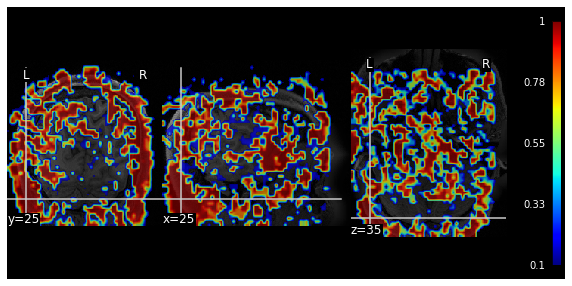

In [25]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(mask_pertrub[0], affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(hcp_dataset[0][0].numpy()),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.1)
plt.show()
fig.savefig('mp_rand_male_1_0.1.png', bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(figsize=(10,5))
roi_img = nib.Nifti1Image(np.clip(mean_mask, a_min=0, a_max=1), affine=np.eye(4))
bim_img  = nib.Nifti1Image(np.squeeze(X[0]),affine=np.eye(4))
plotting.plot_roi(roi_img,bim_img,cut_coords=(25,25,35), axes=axes,colorbar=True,cmap='jet',threshold=0.55)
plt.show()
fig.savefig('meaningful perturbation.png', bbox_inches='tight')